# Chapter 14: Build A GPT from Scratch




LSTM models work well with short and relatively long patterns. However, when the interdependencies among words are extremely long, such as in long text files, LSTM models fail. Because of this, researchers started to add the attention mechanism to language models to compensate for this shortcoming. A 2017 paper by Google researchers, aptly titled "Attention is all you need", shows that we can abandon RNN networks altogether and use only attention layers to capture the long-term relationships between words in natural language processing. The network architecture is known as Transformers. 

In this chapter, you'll learn what the attention mechanism is and the structure of transformer models. In particular, you'll create a transformer that's identical to OpenAI's GPT2 (GPT stands for generative pretrained transformer) from scratch. You'll load the trained weights from GPT2 and start to generate text that are close to human written.

The Python code in this chapter is adapted from Andrej Karpathy's GitHub minGPT repository https://github.com/karpathy/minGPT, which in turn is a PyTorch re-implementation of OpenAI's GPT2 model https://github.com/openai/gpt-2. 

Start a new cell in ch14.ipynb and execute the following lines of code in it:

In [1]:
import os

os.makedirs("files/ch14", exist_ok=True)

# 1. Word Tokenization and the Attention Mechanism
Before we create the model, let's first discuss how we tokenize words in GPT2 and the idea behind the self attention mechanism.

## 1.1. The Byte Pair Encoder
In Chapter 12, we tokenized words from scratch. Basically we converted all the words in the text into integers and feed the integers to the models to train them. 

OpenAI uses a more efficient way of tokenizing words: Byte Pair Encoder. Download the file *bpe.py* from Andrej Karpathy's GitHub minGPT repository https://github.com/karpathy/minGPT/blob/master/mingpt/bpe.py and place the file in the folder /Desktop/ai/utils/ on your computer. 

Take a look at the file. If it sounds too complicated, you don't need to spend too much time on it. All you need to know is that it converts a string of text into a sequence of integers. 

To see how the module *bpe.py* converts text into integers, let's try an example:

In [2]:
from utils.bpe import get_encoder

example="This is the original text that we want to convert it to integers."
bpe_encoder=get_encoder()
response=bpe_encoder.encode_and_show_work(example)
print(response)

{'bpe_idx': [1212, 318, 262, 2656, 2420, 326, 356, 765, 284, 10385, 340, 284, 37014, 13], 'tokens': ['This', ' is', ' the', ' original', ' text', ' that', ' we', ' want', ' to', ' convert', ' it', ' to', ' integers', '.'], 'parts': [{'token': 'This', 'token_bytes': b'This', 'token_translated': 'This', 'token_merged': ['This'], 'token_ix': [1212]}, {'token': ' is', 'token_bytes': b' is', 'token_translated': 'Ġis', 'token_merged': ['Ġis'], 'token_ix': [318]}, {'token': ' the', 'token_bytes': b' the', 'token_translated': 'Ġthe', 'token_merged': ['Ġthe'], 'token_ix': [262]}, {'token': ' original', 'token_bytes': b' original', 'token_translated': 'Ġoriginal', 'token_merged': ['Ġoriginal'], 'token_ix': [2656]}, {'token': ' text', 'token_bytes': b' text', 'token_translated': 'Ġtext', 'token_merged': ['Ġtext'], 'token_ix': [2420]}, {'token': ' that', 'token_bytes': b' that', 'token_translated': 'Ġthat', 'token_merged': ['Ġthat'], 'token_ix': [326]}, {'token': ' we', 'token_bytes': b' we', 'tok

In particular, the example text has 13 words and a punctuation (.) in it. That's a total of 14 items. The encoder converts them into 14 integers, as follows:

In [3]:
print(response['bpe_idx'])

[1212, 318, 262, 2656, 2420, 326, 356, 765, 284, 10385, 340, 284, 37014, 13]


Therefore, we'll use the BPE encoder as our tokenizer. 

## 1.2. The Self Attention Mechanism
To understand the attention mechanism, we need to go back to recurrent neural networks (RNNs). RNNs such as LSTMs need to keep track of the hidden state to account for information in previous time steps. For small datasets RNNs work well, as you have seen in Chapter 11 when we use a character-level LSTM model to learn to generate Shakespeare-style text. 

However, for large language models, the number of hidden states the model needs to track is large. This leads to both poor performance and long training time. Researchers add in the attention mechanism to let the model know which states to pay more attention to. The attention mechanism leads to better RNN models. However, since in recurrent models the learning is sequential, paralleled computing is not feasible. 

A paper in 2017 by Google researchers proposes a solution: abandon the RNN model and keep only the attention mechanism, and use multi-headed attention mechanisms for parallel computing. The model architecture they proposed is dubbed transformers. 

Now let's discuss how the attention mechanism is implemented. Attention is a mechanism that allows the model to assign different amounts of weights to elements in a sequence. These weights are learned from large amounts of data during the training stage. Specifically, the weights are calculated from queries Q, keys K, and values V, with the following formula:
$$Attention(Q,K,V)=softmax(\frac{Q\times K_{transpose}}{\sqrt{d_k}})\times V$$

# 2. The GPT2 Model
In this section, we'll create the GPT2 model from scratch. Along the way, you'll learn how the attention mechanism works and the architecture of the GPT2.  

Download the file *gpt2_utils.py* from the book's GitHub repository and place it in the folder /Desktop/ai/utils/ on your computer. In it, we have defined a few helper functions and the transformer model. 

## 2.1. The GELU Activation Function
Instead of using the ReLU activation function, we'll use the GELU activation function. The function is defined as follows.

In [4]:
from torch import nn

class NewGELU(nn.Module):
    def forward(self, x):
        return 0.5*x*(1.0+torch.tanh(math.sqrt(2.0/math.pi)*\
                       (x + 0.044715 * torch.pow(x, 3.0))))

The ReLU function is not differentiable since it has a kink in it. The GELU activation function, in contrast, is differentiable everywhere and provides better learning process. Below, we draw a picture of the GELU function and compares it to the ReLU function:

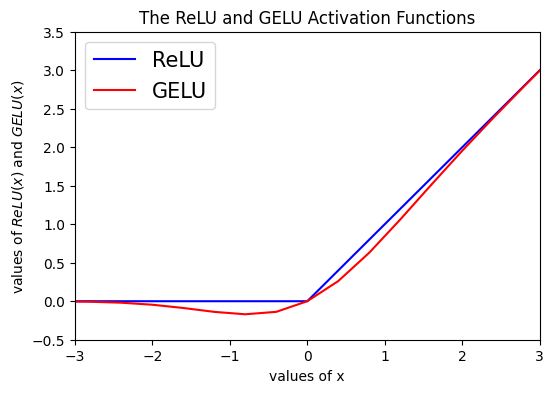

In [5]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

GELU=NewGELU()
         
# Define GELU and ReLU
def relu(x):
    y=torch.zeros(len(x))
    for i in range(len(x)):
        if x[i]>0:
            y[i]=x[i]
    return y  
def gelu(x):
    y=torch.zeros(len(x))
    for i in range(len(x)):
        y[i]=NewGELU(x[i])
    return y                 
# Generate x values
xs = torch.linspace(-6,6,31)
ys=relu(xs)
#gs=gelu(xs)
gs=GELU(xs)

# Plot the ReLU function
fig, ax = plt.subplots(figsize=(6,4),dpi=100)
plt.xlim(-3,3)
plt.ylim(-0.5,3.5)
#plt.grid()

plt.plot(xs, ys, color = 'blue', label="ReLU")
plt.plot(xs, gs, color = 'red', label="GELU")
plt.legend(fontsize=15)
plt.xlabel("values of x")
plt.ylabel("values of $ReLU(x)$ and $GELU(x)$")
plt.title("The ReLU and GELU Activation Functions")
plt.show()

The above graph shows that GELU is a smooth function hence differentiable everywhere. 

## 2.2 Create A Transformer
We first define some hyperparameters, which are based on the XL version of the GPT2 model. The easiest way to accomplish this is to define a Config() class with default values:

In [6]:
# define hyperparameters
class Config():
    def __init__(self, n_layer = 48, n_head = 25, 
        n_embd = 1600, vocab_size = 50257, block_size = 1024,
        embd_pdrop = 0.1, resid_pdrop = 0.1, attn_pdrop = 0.1):
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.vocab_size = vocab_size
        self.block_size = block_size 
        self.embd_pdrop = embd_pdrop 
        self.resid_pdrop = resid_pdrop 
        self.attn_pdrop = attn_pdrop 
        
# instantiate a Config() class
config=Config()

In particular, the GPT2 XL model uses 48 layers of attention blocks, each with 25 parallel attention heads. 

The attention mechanism is modeled in the *CausalSelfAttention()* class, which is defined as follows in the file *gpt2_util.py*. 

In [7]:
# see ExplainSelfAttention.py for how it works
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.register_buffer("bias", torch.tril(torch.ones(\
                   config.block_size, config.block_size))
             .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() 
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        hs = C // self.n_head
        k = k.view(B, T, self.n_head, hs).transpose(1, 2) 
        q = q.view(B, T, self.n_head, hs).transpose(1, 2) 
        v = v.view(B, T, self.n_head, hs).transpose(1, 2) 

        att = (q @ k.transpose(-2, -1)) *\
            (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, \
                              float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v 
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

Note that the attention weights are calculated from the three vectors, q, k, and v. The weights in these three vectors are learned from the data during training. 

GPT2 belongs to the decoder family and the XL version consists of 48 attention blocks. Each attention block is defined as follows: 

In [8]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc   = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj = nn.Linear(4 * config.n_embd, config.n_embd),
            act    = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf=lambda x:m.dropout(m.c_proj(m.act(m.c_fc(x)))) 

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

The main component in the attention block is the *CausalSelfAttention()* class we defined above. However, the inputs are first normalized and the residual then added to the inputs. After that, the inputs go through the *CausalSelfAttention()* class and the output is normalized again. The outputs then go through a feed-forward sublayer, which consists of two fully connected dense layers. 

The GPT2 model is defined as follows:

In [9]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) 
                               for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd,
                                 config.vocab_size, bias=False)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, 
                  std=0.02/math.sqrt(2 * config.n_layer))
        num=sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (num/1e6,))
            
    def forward(self, idx, targets=None):
        b, t = idx.size()
        pos = torch.arange(0,t,dtype=torch.long).unsqueeze(0)
        tok_emb = self.transformer.wte(idx) 
        pos_emb = self.transformer.wpe(pos) 
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss=F.cross_entropy(logits.view(-1,logits.size(-1)),
                           targets.view(-1), ignore_index=-1)
        return logits, loss

Finally, we instantiate a GPT2 model as follows:

In [10]:
model=GPT(config)

number of parameters: 1557.61M


Just like that, you have created a GPT2 model from scratch. The model is, of course, not trained. So it cannot make any meaningful predictions or generate any legible text. 

As you can see, the model has more than 1.5 billion parameters and it's impossible to train the model without supercomputing facilities, let alone the amount of data needed to train the model. 

We, therefore, will load up the trained weights that are published by OpenAI. 

# 3. Load Up the Trained Weights

To load up the pretrained weights from GPT2, we can first import GPT2 from the *transformers* library and extract the model weights:

In [11]:
from transformers import GPT2LMHeadModel

model_hf = GPT2LMHeadModel.from_pretrained('gpt2-xl')
sd_hf = model_hf.state_dict()  

We'll see how many keys are in the dictionary *sd_hf*:

In [12]:
keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')] 
print(len(keys))

629


We'll also extract the state dictionary for the GPT2 model we just created ourselves:

In [13]:
sd=model.state_dict()
print(len(sd))

629


Because OpenAI uses a "Conv1D" module while we use a vanilla nn.Linear, we need to transpose these weights when we import them to our model:

In [14]:
transposed = ['attn.c_attn.weight', 'attn.c_proj.weight',
              'mlp.c_fc.weight', 'mlp.c_proj.weight']

We'll go ahead and load the trained weights from the trained model to our own model, layer by layer:

In [15]:
for k in keys:
    if any(k.endswith(w) for w in transposed):
        # special treatment for Conv1D weights
        with torch.no_grad():
            sd[k].copy_(sd_hf[k].t())
    else:
        with torch.no_grad():
            sd[k].copy_(sd_hf[k])

Now our model is equiped with trained weights from OpenAI. 

# 4. Text Generation with GPT2
We'll use the GPT2 model to generate text. 

When generating text, we will feed a prompt to the model. The model predicts the next word and attaches the prediction to the end of the prompt to form a new prompt. It then uses the new prompt to make prediction again. It keep doing this until the desired text length is reached. 

First, we need to define a function to convert text to integers to feed to the model and after the prediction is finished, convert integers back to text. 

In [16]:
def sample(idx, max_new_tokens, temperature=1.0,
             do_sample=False, top_k=None):
    for _ in range(max_new_tokens):
        if idx.size(1) <= config.block_size:
            idx_cond = idx  
        else:
            idx_cond = idx[:, -config.block_size:]
        # predict the logits for the index in sequence
        logits, _ = model(idx_cond)
        # pluck the logits at the final step 
        logits = logits[:, -1, :] / temperature
        # crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1)
        if do_sample:
            idx_next=torch.multinomial(probs,num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

We will provide a prompt and convert it to integers:

In [17]:
from utils.bpe import BPETokenizer   

tokenizer = BPETokenizer()
prompt="The city of Lexington in the state of Kentucky"

x=tokenizer(prompt)
print(x)  

tensor([[  464,  1748,   286, 39540,   287,   262,  1181,   286, 11867]])


Here I use "The Finance department at the University of Kentucky" as the prompt. We convert the text to integers so we can feed to the GPT2 model:  

In [18]:
y = sample(x, max_new_tokens=200, do_sample=True, top_k=40)    

We'll generate 200 words. We turn on the *do_sample* option, and this means the model randomly chooses the top 40 words in each step, based on the proability assigned to these 40 words. 

Finally, we need to convert the integers back to text, as follows:

In [19]:
out=tokenizer.decode(y[0].squeeze())   
print(out)

The city of Lexington in the state of Kentucky, is also offering a $300 award to "Owner" PANZER-KATZ FOR BEST LENGTH OF STREET CARS, or just "For the Best Street Car" in any of their three categories:

4WD (3.5 miles or less)

6WD (3.5 miles or more)

FWD (3.5 miles or more)

And this is for the BEST street car in the 4WD category:

The "Neato" (pronounced "Nice")

What is it with those 4WD cars and their "Neato" names? This is probably one of the most well-know 4WD names in the history of 4WD cars. It is so well known that there are a multitude of books dedicated to the design and specifications of "Nice" 4WD cars, such as this one from Michael B. Smith, which is a good read.

But as of right


The generated text sounds real. But I did a Google search and the story is not true and it's not taken from any existing source. That is, GPT2 is able to generate believable stories based on the trained model. 